In [115]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,f1_score, recall_score, make_scorer


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# new imports
from xgboost import XGBClassifier
import shap

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

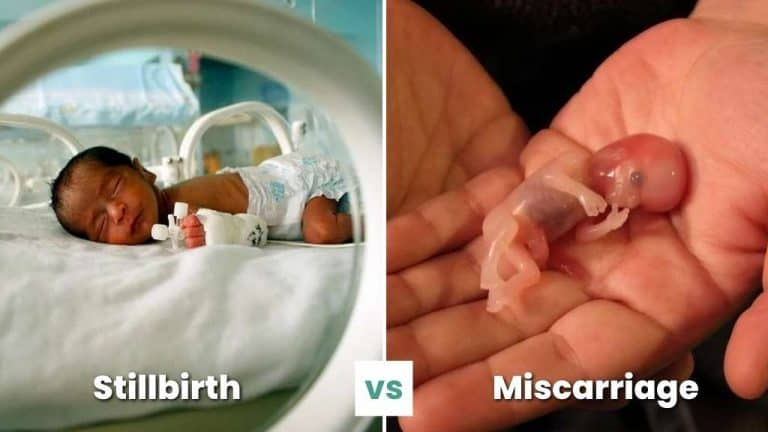

### Data Loading

In [116]:
df=pd.read_excel('cardiotocography.xls')
df.head()

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0


In [117]:
df.shape

(2130, 40)

### Data Preprocessing

In [118]:
df.isnull().sum()

FileName    4
Date        4
SegFile     4
b           4
e           4
LBE         4
LB          4
AC          4
FM          3
UC          3
ASTV        3
MSTV        3
ALTV        3
MLTV        3
DL          2
DS          2
DP          2
DR          2
Width       4
Min         4
Max         4
Nmax        4
Nzeros      4
Mode        4
Mean        4
Median      4
Variance    4
Tendency    4
A           4
B           4
C           4
D           4
E           4
AD          4
DE          4
LD          4
FS          4
SUSP        4
CLASS       4
NSP         4
dtype: int64

In [110]:
df.dropna(inplace=True)

In [119]:
df.duplicated().sum()

1

In [120]:
df.drop_duplicates(inplace=True)

In [121]:
df.duplicated().sum()

0

In [111]:
df.describe()

,Date,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2126,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,1996-04-22 16:59:22.746942592,878.439793,1702.877234,133.303857,133.303857,2.722484,7.241298,3.659925,46.990122,1.332785,...,0.024929,0.038100,0.033866,0.156162,0.118532,0.050329,0.032455,0.092662,4.509878,1.304327
min,1980-01-04 00:00:00,0.000000,287.000000,106.000000,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1996-05-02 00:00:00,55.000000,1009.000000,126.000000,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,1996-08-21 00:00:00,538.000000,1241.000000,133.000000,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,1997-03-20 00:00:00,1521.000000,2434.750000,140.000000,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
max,1998-06-06 00:00:00,3296.000000,3599.000000,160.000000,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,3.000000
std,NaN,894.084748,930.919143,9.840844,9.840844,3.560850,37.125309,2.847094,17.192814,0.883241,...,0.155947,0.191482,0.180928,0.363094,0.323314,0.218675,0.177248,0.290027,3.026883,0.614377


In [112]:
df.head()

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
1,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
5,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


In [113]:
df.shape

(2126, 40)

In [114]:
df['NSP'].value_counts()

NSP
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2126 entries, 1 to 2126
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   FileName  2126 non-null   object        
 1   Date      2126 non-null   datetime64[ns]
 2   SegFile   2126 non-null   object        
 3   b         2126 non-null   float64       
 4   e         2126 non-null   float64       
 5   LBE       2126 non-null   float64       
 6   LB        2126 non-null   float64       
 7   AC        2126 non-null   float64       
 8   FM        2126 non-null   float64       
 9   UC        2126 non-null   float64       
 10  ASTV      2126 non-null   float64       
 11  MSTV      2126 non-null   float64       
 12  ALTV      2126 non-null   float64       
 13  MLTV      2126 non-null   float64       
 14  DL        2126 non-null   float64       
 15  DS        2126 non-null   float64       
 16  DP        2126 non-null   float64       
 17  DR        2126 non-

In [14]:
#Meta colums to drop
drop_cols=['FileName','Date','SegFile']
df.drop(columns=drop_cols,inplace=True)

In [15]:
df.head(1)

,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
1,240.0,357.0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0


### Pearson Correlation

In [19]:
corr_matrix = df.corr(method='pearson')
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# find columns to drop
to_drop = [col for col in upper.columns if any(upper[col].abs() > 0.98)]
print("Highly‑correlated features to consider dropping:", to_drop)

Highly‑correlated features to consider dropping: ['LB']


In [20]:
to_drop

['LB']

In [21]:
df.drop(columns=to_drop,inplace=True)

In [22]:
df.shape

(2126, 36)

### Machine Learning Algorithms

In [23]:
# 2. Define feature matrix X and target y
X = df.drop(columns=['NSP','CLASS'])
y = df['NSP']-1  # values 1,2,3

In [24]:
# 3. Train/test split (with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [25]:
def evaluate_model(model_name, y_true, y_pred, results_list):
    """Calculates performance metrics and appends them to a list of results."""
    metrics = {
        'Model': model_name,
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall':    recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1-Score':  f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'Accuracy' : accuracy_score(y_true, y_pred)
    }
    results_list.append(metrics)
    print(f"Metrics for {model_name} calculated.")

In [26]:
# A list to hold the results from each model
all_results = []

# --- 1. Decision Tree ---
print("Training Decision Tree...")
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
evaluate_model('DecisionTree', y_test, y_pred_dt, all_results)


# --- 2. Random Forest ---
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
evaluate_model('RandomForest', y_test, y_pred_rf, all_results)


# --- 3. XGBoost ---
print("\nTraining XGBoost...")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
evaluate_model('XGBoost', y_test, y_pred_xgb, all_results)


# --- 4. Create and display the final summary table ---
df_results = pd.DataFrame(all_results).set_index('Model')
print("\n--- Model Comparison ---")
display(df_results.round(3))

Training Decision Tree...
Metrics for DecisionTree calculated.

Training Random Forest...
Metrics for RandomForest calculated.

Training XGBoost...
Metrics for XGBoost calculated.

--- Model Comparison ---


,Precision,Recall,F1-Score,Accuracy
Model,,,,
DecisionTree,0.981,0.981,0.981,0.981
RandomForest,0.977,0.977,0.976,0.977
XGBoost,0.984,0.984,0.983,0.984


# HyperParameter Tuning

In [28]:
# 1. Define the XGBoost model
# We instantiate the model directly since we are not using a pipeline.
xgb_model = XGBClassifier(
    eval_metric='mlogloss', 
    use_label_encoder=False, 
    random_state=42
)

# 2. Define the search space for XGBoost
# The 'clf__' prefix is removed from parameter names because we aren't using a pipeline.
search_space_xgb = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 0.5, prior='log-uniform'),
    'max_depth': Integer(3, 15),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}

# 3. Set up and run Bayesian Optimization
# We define the F1 score as our target for optimization.
f1_scorer = make_scorer(f1_score, average='weighted')

opt = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=search_space_xgb,
    n_iter=30,          # Number of parameter settings that are sampled
    scoring=f1_scorer,
    cv=3,               # 3-fold cross-validation
    n_jobs=-1,          # Use all available CPU cores
    random_state=42,
    verbose=0
)

print("--- Tuning XGBoost ---")
opt.fit(X_train, y_train)

# 4. Summarize the results in a table
results = [{
    'Model': 'XGBoost',
    'Best CV F1': opt.best_score_,
    'Best Params': opt.best_params_
}]

df_results = pd.DataFrame(results).set_index('Model')
pd.set_option('display.max_colwidth', None) # Ensures the full dictionary of parameters is visible
display(df_results)

--- Tuning XGBoost ---


,Best CV F1,Best Params
Model,,
XGBoost,0.992317,"{'colsample_bytree': 0.8670140089927842, 'learning_rate': 0.3944218875870816, 'max_depth': 5, 'n_estimators': 135, 'subsample': 0.9002516157283724}"


### SHAP Explainability

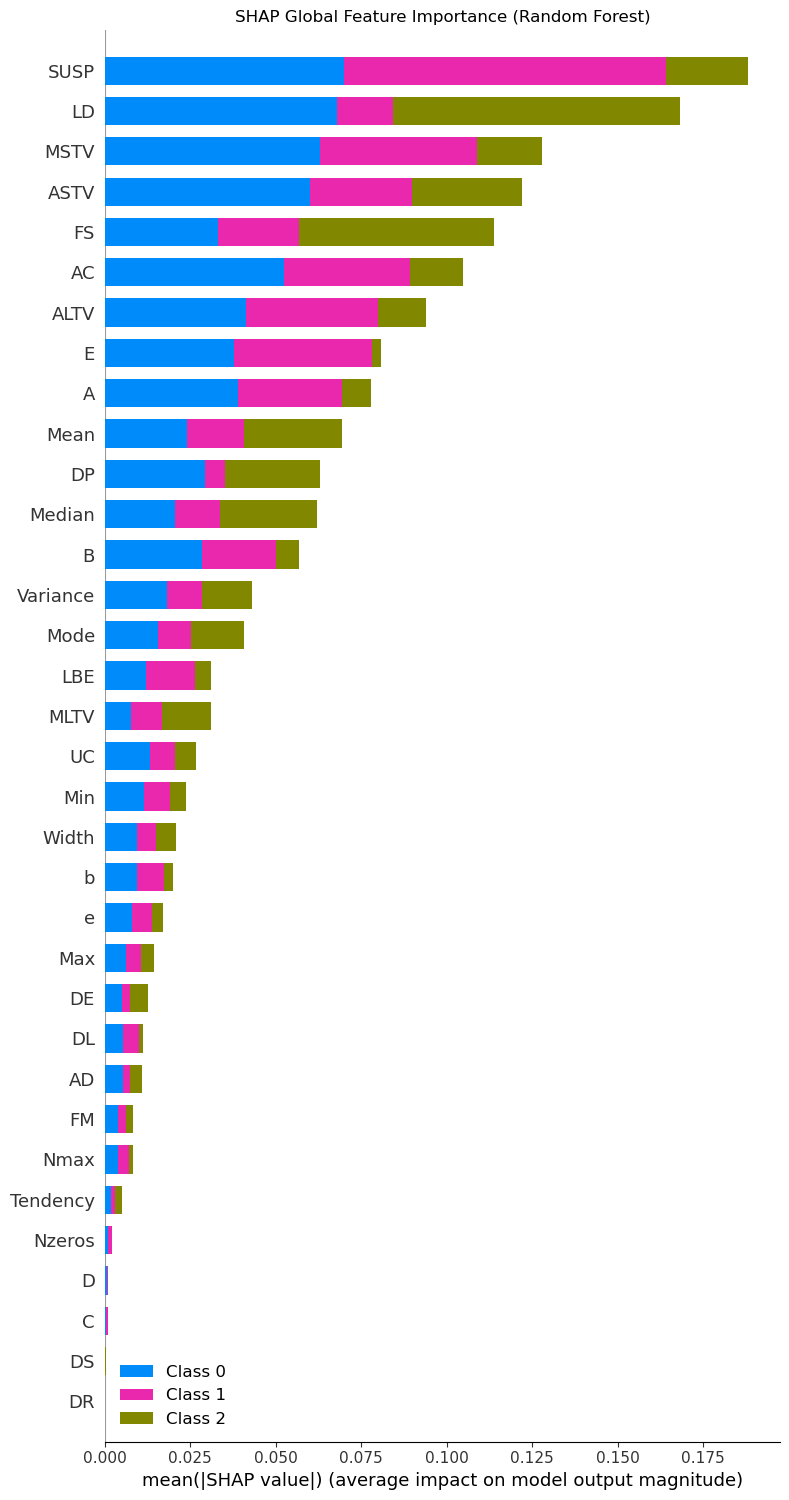

In [29]:


# The 'rf_model' variable should already hold your trained Random Forest model.
# Example:
# rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
# rf_model.fit(X_train, y_train)

# 1. Create a SHAP TreeExplainer using the trained model
explainer = shap.TreeExplainer(rf_model)

# 2. Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# 3. Create a bar plot of global feature importance
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X_test.columns,
    plot_type="bar",               # Use a bar chart for global importance
    max_display=X_test.shape[1],   # Ensure all features are shown
    show=False                     # We will call plt.show() manually
)

# 4. Customize and save the plot
plt.title("SHAP Global Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()